In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, mode
from math import sqrt
import time 
import numpy as np
import matplotlib.animation as animation
%matplotlib inline
from scipy import signal
import math
from sklearn.metrics import mean_squared_error
import scipy.optimize as optimize
import scipy.io as sio
import scipy.signal as signal
import itertools
from scipy.fftpack import fft, ifft
plt.style.use('seaborn')

#### First task figure out a numerical integration scheme for the readout   
* Completed I use an approximation of the dirac delta function which can be numerically integrated
#### Find the list of parameters that gives a nice readout pattern 

* The individual oscillation period of the cells i.e. the period of w 
* The collective oscillation period of the entire organism after delayed coupling or coupling
* The length of the somites that I am getting by following this method and the number of cells in each somite  
* How is the readout related to the length of the somites  
* Need the physical meaning of some of the parameters and the feasible values thats missing right now 

All the above values can be found in the literature  
This further will tell me if the parameters that I am using are correct or not 
#### Characterise the readout pattern using some kind of methodology and make statements about patterns etc  
* One way is to collect statistics about the rmax and rmin and the oscillation thresholds  
* Another way would be the statistics on somites 
* Autocorrelation and PSD are some of the other methods 

In [44]:
param_dic = {"c":8, "n_t":200, "dt": 0.05, "gamma1":10, "n": 5, "m": 5, "tau_2":5, "gamma2":1, "n_c":100, "dx":1.5,
            "v_0": 1.5, "tau_d": 7,"beta":0.05, "u_0": 0.5, "K_u": 0.3, "tol":1e-6, "loc": 4}


In [166]:
def plot_histogram_of_extrema_min_max(r):
    r_max = find_vals_of_r_extrema(r, "max")
    r_min = find_vals_of_r_extrema(r, "min")
    
    f, (ax1, ax2) = plt.subplots(1, 2)

    ax1.hist(r_max, bins=15, density=True, alpha=0.6, color='r')
    ax2.hist(r_min, bins=15, density=True, alpha=0.6, color='g')

    
def find_vals_of_r_extrema(r2d, type=None):
    if (type == "max"):
        extrema  = signal.argrelextrema(r2d, np.greater)
    else:
        extrema  = signal.argrelextrema(r2d, np.less)
    return r[extrema]



def dist_between_peaks(peaks, dx):
    dist = []
    for i in range(1, len(peaks)):
        dist.append(dx*(peaks[i]-peaks[i-1]))
    dist = np.asarray(dist)
    stats = np.unique(dist, return_index=False, return_inverse=False, return_counts=True, axis=None)
    return stats, np.average(dist), mode(dist).mode[0], peaks, dist


def extract_somite_statistics_from_readout(r2d, dx):
    peaks, _ = signal.find_peaks(r2d)
    extrema_g,  = signal.argrelextrema(r2d, np.greater)
    extrema_l,  = signal.argrelextrema(r2d, np.less)
    np.append(extrema_l, 0)
    if extrema_g[0]<extrema_l[0]:
        peaks =np.asarray( list(itertools.chain(*zip(list(extrema_g), list(extrema_l))))[:-1])
    else:
        peaks =np.asarray( list(itertools.chain(*zip(list(extrema_l), list(extrema_g))))[:-1])

    return dist_between_peaks(peaks, dx)
def return_heaviside(n_c, n_t, dx, dt, v_0):
    ha2d = np.ones((n_c, n_t))
    for i in range(n_t):
        for j in range(n_c):
            ha2d[j][i] = int((j*dx - v_0*i*dt)>0)
    return ha2d

def plot_fft_of_readout(r, x):
    fft_r = fft(r)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(x,fft_r)
    ax.set_title("fft of r vs x")

def run_sim_wout_coupling_and_noise(dic, plot=False):
    u2d = np.ones((dic["n_c"], dic["c"]*dic["n_t"]))
    w2d = np.zeros((dic["n_c"], dic["c"]*dic["n_t"]))
    r2d = np.zeros(dic["n_c"])
    t = np.asarray([i*dic["dt"] for i in range(dic["n_t"]*dic["c"])])
    x_ = np.asarray([i*dic["dx"] for i in range(dic["n_c"])])
    ha2d = return_heaviside(dic["n_c"], dic["n_t"]*dic["c"], dic["dx"], dic["dt"], dic["v_0"])
    
    for i in range(dic["c"]*dic["n_t"]-1):
        for cell in range(1, dic["n_c"]-1):
            u2d[cell][i+1] = u2d[cell][i] + dic["dt"]*(-u2d[cell][i]*(1/dic["tau_2"])+ (1/dic["tau_2"])*ha2d[cell][i])
            if (i - dic["tau_d"] >= 0):
                w2d[cell][i+1] = w2d[cell][i] + dic["dt"]*(-w2d[cell][i] + dic["gamma1"]*(u2d[cell][i]**dic["n"]/(u2d[cell][i]**dic["n"]+dic["K_u"]**dic["n"]))*(1/(1+w2d[cell][i-dic["tau_d"]]**dic["m"]))   )
            else:
                w2d[cell][i+1] = w2d[cell][i] + dic["dt"]*(-w2d[cell][i] + dic["gamma1"]*(u2d[cell][i]**dic["n"]/(u2d[cell][i]**dic["n"]+dic["K_u"]**dic["n"]))*(1))
                
    for cell in range(1, dic["n_c"]-1):
        for time in range(1, dic["c"]*dic["n_t"]):
            r2d[cell]  = r2d[cell]+w2d[cell][time]*dirac_delta_approx(u2d[cell][time],dic["u_0"], dic["tol"])*(u2d[cell][time]-u2d[cell][time-1])
    
    if (plot):
        f, (ax) = plt.subplots(2, 2, figsize = (18 ,8))
        
        ax[0, 0].plot(t, ha2d[dic["loc"], :], c = "k")
        ax[0, 0].set_title("heaviside vs t")
        ax[0, 1].plot(t, u2d[dic["loc"], :], c = "r")
        ax[0, 1].set_title("u vs t")
        ax[1, 0].plot(t, w2d[dic["loc"], :], c = "g")
        ax[1, 0].set_title("w vs t")
        ax[1, 1].plot(x_, r2d, c = "b")
        ax[1, 1].set_title("r vs x")
    return u2d, w2d, r2d, ha2d, t, x_

def dirac_delta_approx(ui, u0, eps):
    return max(1-abs(ui/eps), u0)

def plot_peaks_on_readout(r2d, x_, dx):
    f, ax = plt.subplots()
    ax.plot(x_, r2d)
    ax.scatter(peaks*dx, r2d[peaks], c = "r")
    
def plot_individual_cell(w, u, r, h, t, x, loc):
    f, (ax) = plt.subplots(2, 2, figsize = (18 ,8))
        
    ax[0, 0].plot(t, h[loc, :], c = "k")
    ax[0, 0].set_title("heaviside vs t")
    ax[0, 1].plot(t, u[loc, :], c = "r")
    ax[0, 1].set_title("u vs t")
    ax[1, 0].plot(t, w[loc, :], c = "g")
    ax[1, 0].set_title("w vs t")
    ax[1, 1].plot(x, r, c = "b")
    ax[1, 1].set_title("r vs x")
    
def get_oscillations_of_w_single_cell(w2d, t):
    peaks, _ = signal.find_peaks(w2d)
    extrema_g,  = signal.argrelextrema(w2d, np.greater)
    extrema_l,  = signal.argrelextrema(w2d, np.less)
    w_max = w2d[extrema_g]
    w_min = w2d[extrema_l]
    t_p_max = t[extrema_g]
    t_max = np.asarray([x - t_p_max[i - 1] for i, x in enumerate(t_p_max)][1:])
    t_p_min = t[extrema_l]
    t_min = np.asarray([x - t_p_min[i - 1] for i, x in enumerate(t_p_min)][1:])
    np.append(extrema_l, 0)
    if extrema_g[0]<extrema_l[0]:
        peaks =np.asarray( list(itertools.chain(*zip(list(extrema_g), list(extrema_l))))[:-1])
    else:
        peaks =np.asarray( list(itertools.chain(*zip(list(extrema_l), list(extrema_g))))[:-1])

    return w_max, w_min, t_max, t_min
    

In [188]:
param_dic["v_0"] = 4.0
param_dic["u_0"] = .75
param_dic["dt"] = 0.1
param_dic["gamma1"] = 10
param_dic["gamma2"] = 1
param_dic["dx"] = 1.5
param_dic["tau_d"] = 7
param_dic["c"] = 15





u, w, r, h, t, x = run_sim_wout_coupling_and_noise(param_dic, plot = False)
#somite_stats, avg_size, mode_size, peaks, dist = extract_somite_statistics_from_readout(r, param_dic["dx"])


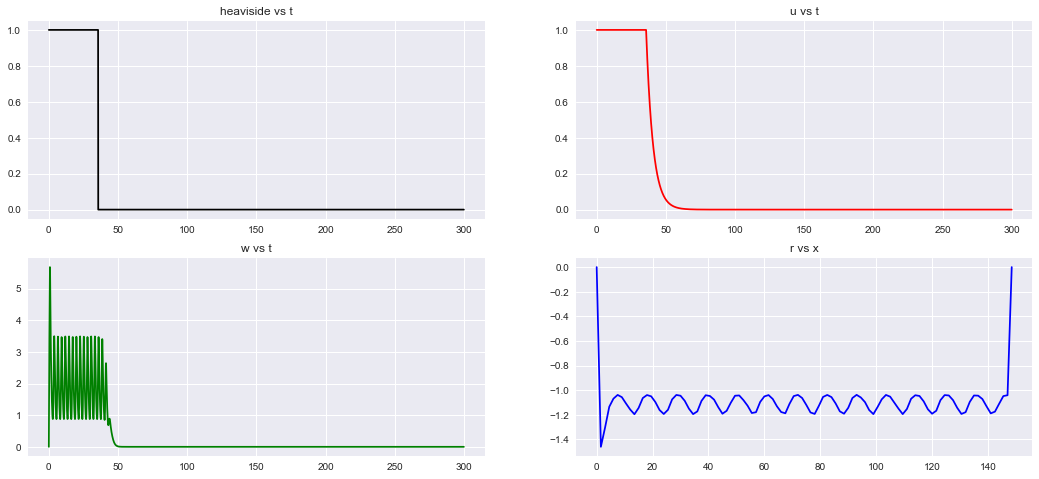

In [189]:
plot_individual_cell(w, u, r, h, t, x, loc = 95)

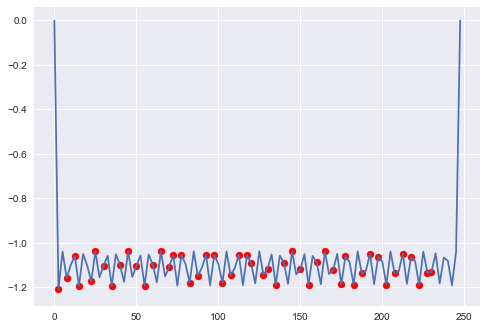

In [178]:
plot_peaks_on_readout(r, x, param_dic["dx"])

In [182]:
w_max, w_min, t_p_max, t_p_min = get_oscillations_of_w_single_cell(w[35, :], t)

In [183]:
t_p_max, t_p_min


(array([3.1, 2.7, 2.6, 2.7, 2.7, 2.7, 2.6, 2.7, 2.7, 2.6, 2.7, 2.7, 2.7,
        2.6, 2.7, 2.2]),
 array([2.6, 2.7, 2.7, 2.6, 2.7, 2.7, 2.7, 2.6, 2.7, 2.7, 2.6, 2.7, 2.7,
        2.7, 2.7]))

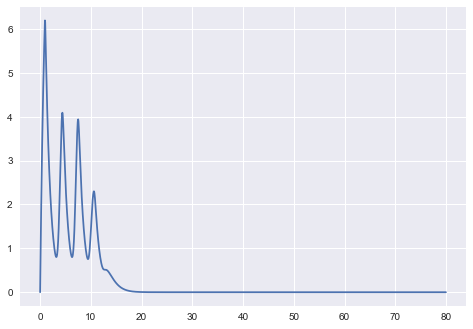

In [123]:
def save_animation(filename, animation_object):# supported format is mp4
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    animation_object.save(filename, writer=writer)

fig = plt.figure()
ax = plt.axes(xlim=(0, 2*x_[-1]), ylim=(np.amin(w2d),1.2*np.amax(w2d)))
ax.set_ylabel("w")
ax.set_xlabel("cell_index_i")
fig.tight_layout()
line, = ax.plot([], [], color='steelblue', lw=2)

def update(num, u, line):
    line.set_data(x_, u[:, num])
    return line,

ani = animation.FuncAnimation(fig, update, n_c, fargs=[ w2d, line],
                              interval=40, blit=True)
plt.show()

In [181]:
#save_animation("w2d.mp4", ani)

In [ ]:
"""
u = np.zeros((n_t))
ha = np.zeros((n_t))

w = np.zeros(( n_t))
cell_pos = 5


for i in range (n_t-1):
    u[i+1] = u[i] + dt*(-u[i]/tau_2 + gamma2)
    if (i - tau_d >= 0):
        w[i+1] = w[i] + dt*(-w[i] + gamma1*(u[i]**n/(u[i]**n+1))*(1/(1+w[i-tau_d]**m))    )
    else:
        w[i+1] = w[i] + dt*(-w[i] + gamma1*(u[i]**n/(u[i]**n+1))*(1)    )

for i in range(n_t):
    ha[i] = int((cell_pos - v_0*i*dt)>0)
        
plt.plot(t, u)


for cell in range(1, n_c-1):
    for time in range(1, n_t-1):
        delta = 1 if u2d[cell][time]-u_0 <= tol else 0
        if (delta == 1):
            print (cell, time)
        r2d[cell]  = r2d[cell] + w2d[cell][time]* delta * (u2d[cell][time+1]-u2d[cell][time])/(dt)

"""